           time         Vp         Vf         Ip        IR
0       0.49998  1675.1927  1658.4583 -58.675827 -1.026645
1       0.50000  1672.8891  1658.1362 -56.146734  2.635738
2       0.50002  1672.5600  1656.5258 -56.937076 -1.531802
3       0.50004  1672.5600  1655.5595 -58.201622 -2.036958
4       0.50006  1673.5473  1652.0164 -62.943670 -2.763120
...         ...        ...        ...        ...       ...
149996  3.49990  1629.1197  1649.1176 -63.259806 -2.542114
149997  3.49992  1626.4869  1648.7955 -60.098441 -1.405512
149998  3.49994  1626.1579  1649.7618 -57.095144  2.698882
149999  3.49996  1622.5378  1647.8292 -56.620939 -0.079477
150000  3.49998  1621.5505  1646.5409 -58.675827 -2.478969

[150001 rows x 5 columns]


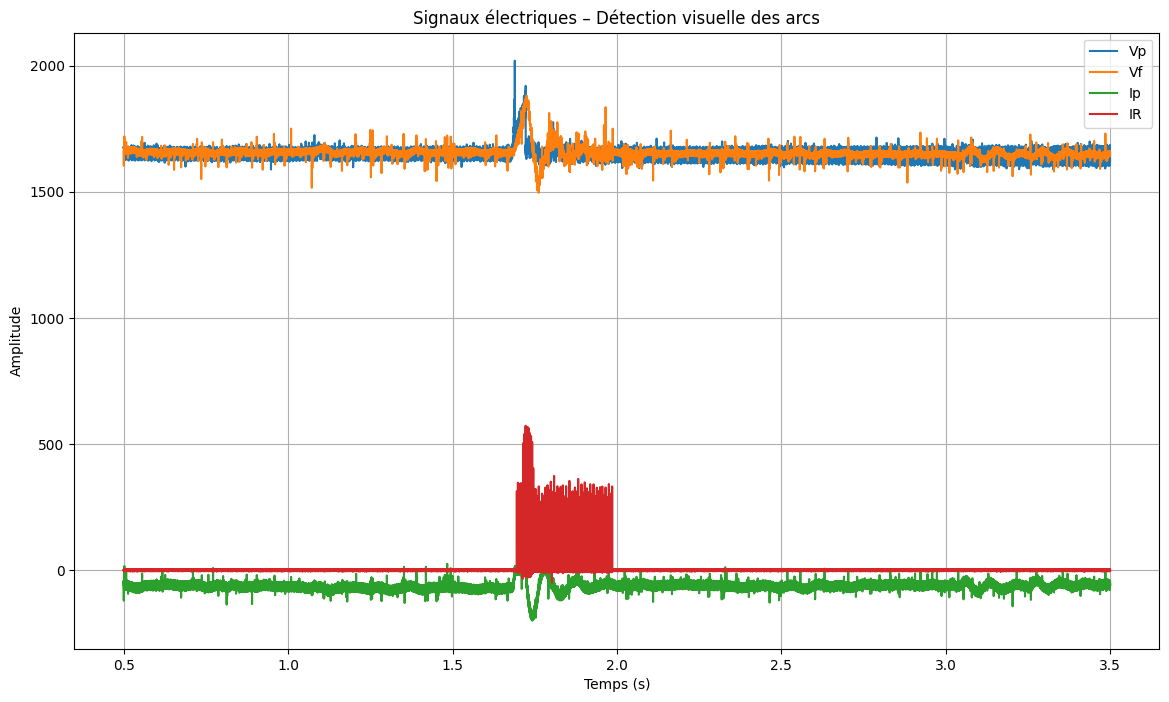

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

Vp1 = pd.read_csv("MM_B_1_Vp.txt", header=None, names=["Vp"])
x1  = pd.read_csv("MM_B_1_x.txt",  header=None, names=["time"])
Vf1 = pd.read_csv("MM_B_1_Vf.txt", header=None, names=["Vf"])
Ip1 = pd.read_csv("MM_B_1_Ip.txt", header=None, names=["Ip"])
IR1 = pd.read_csv("MM_B_1_IR.txt", header=None, names=["IR"])

df1 = pd.concat([x1, Vp1, Vf1, Ip1, IR1], axis=1)
df1.head()
print(df1)


plt.figure(figsize=(14,8))

plt.plot(df1["time"], df1["Vp"], label="Vp")
plt.plot(df1["time"], df1["Vf"], label="Vf")
plt.plot(df1["time"], df1["Ip"], label="Ip")
plt.plot(df1["time"], df1["IR"], label="IR")

plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.title("Signaux électriques – Détection visuelle des arcs")
plt.legend()
plt.grid(True)
plt.show()

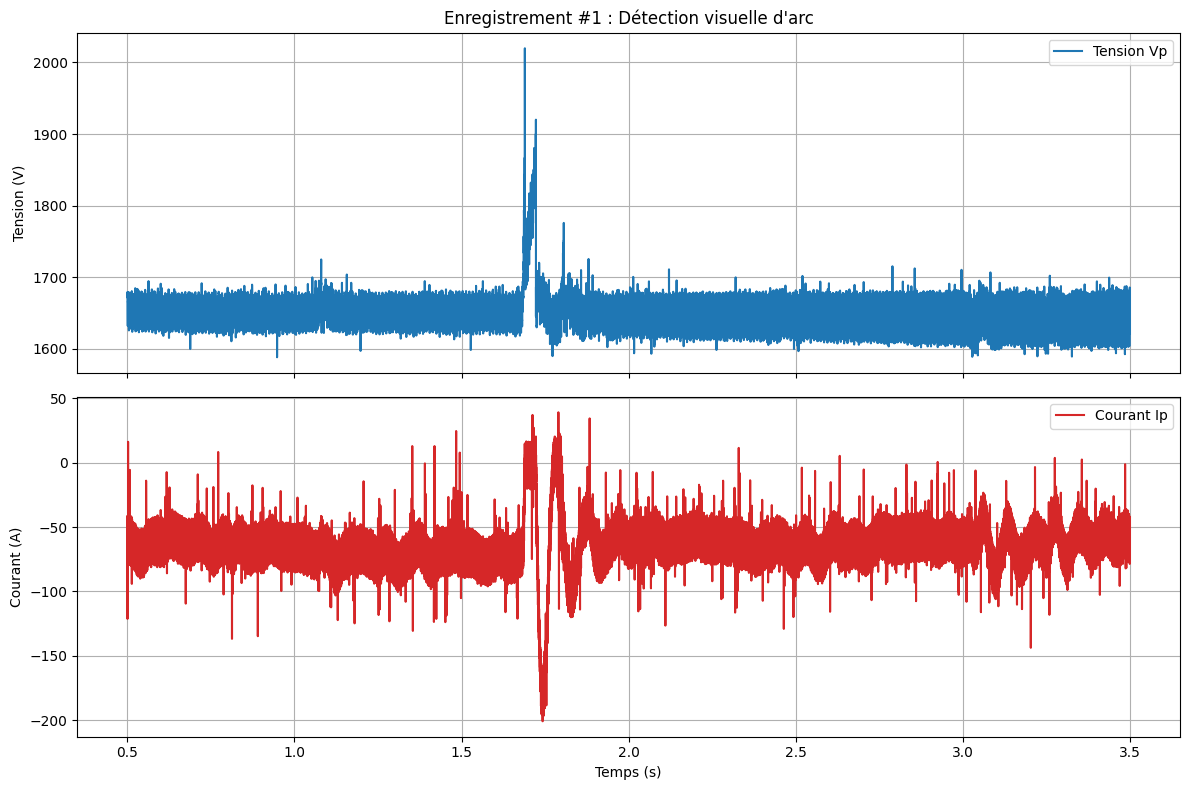

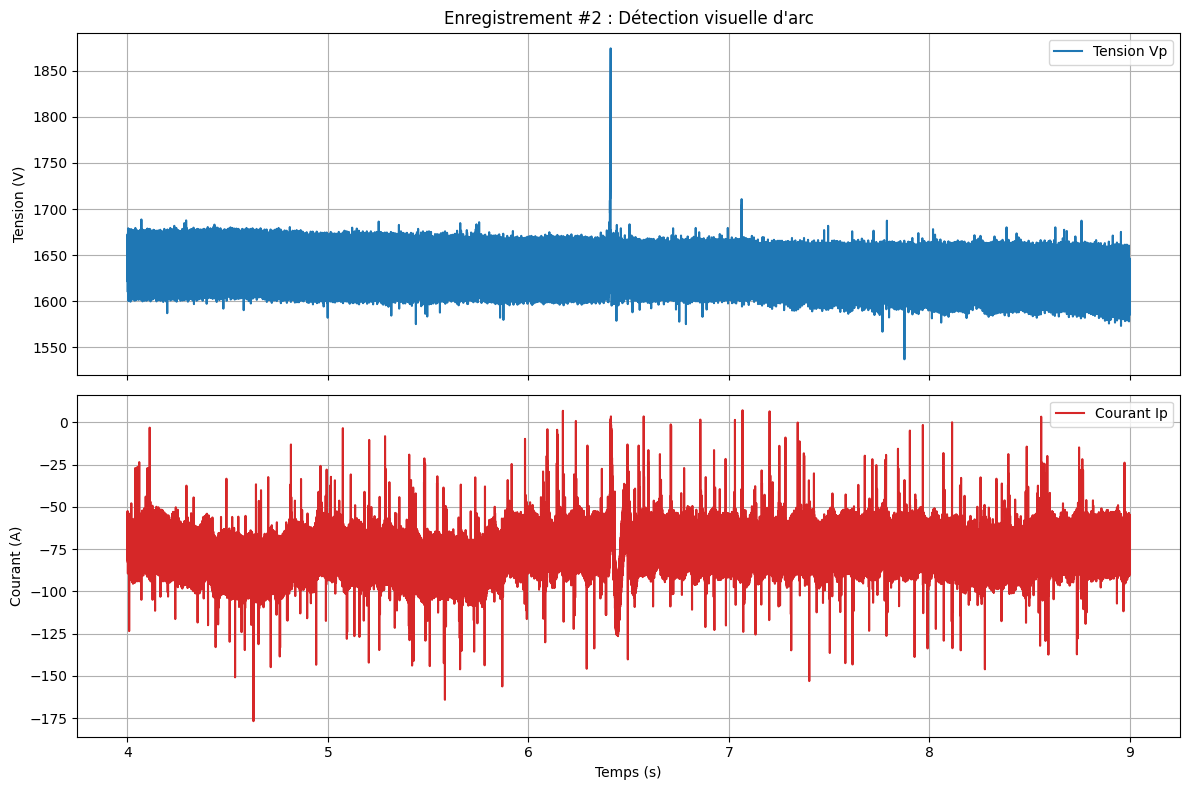

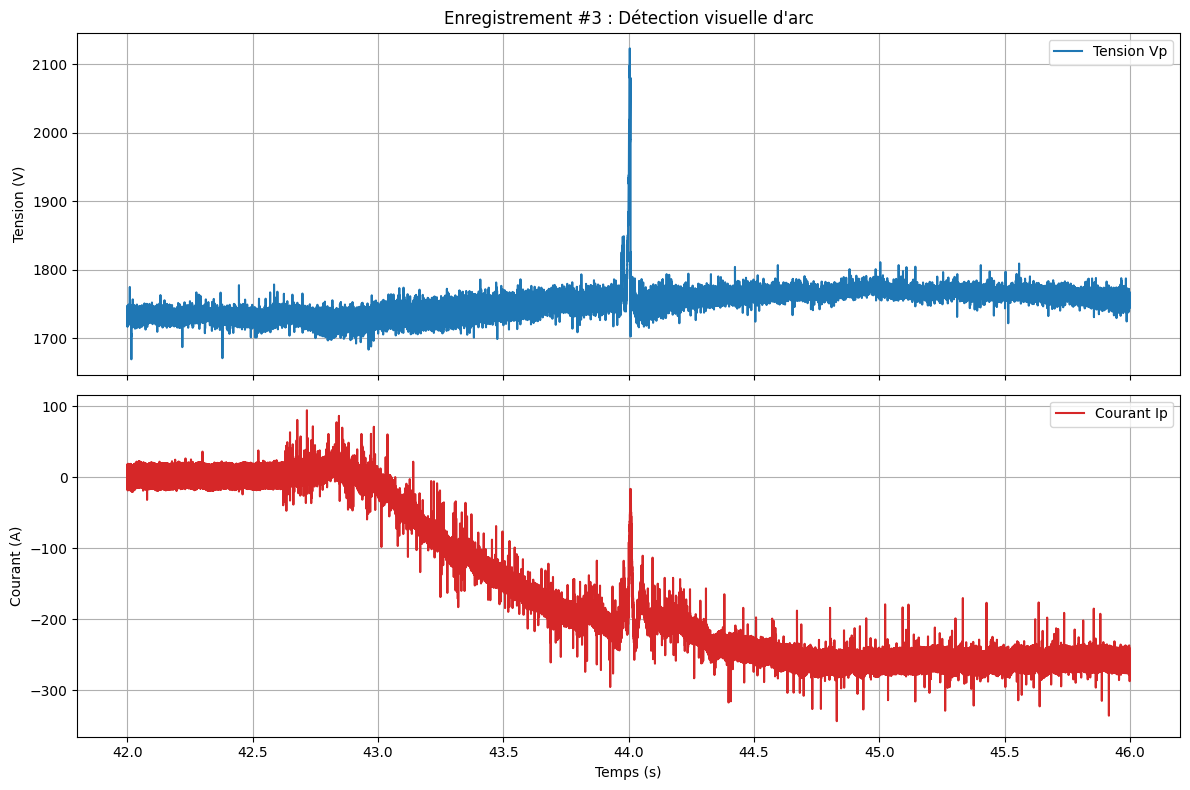

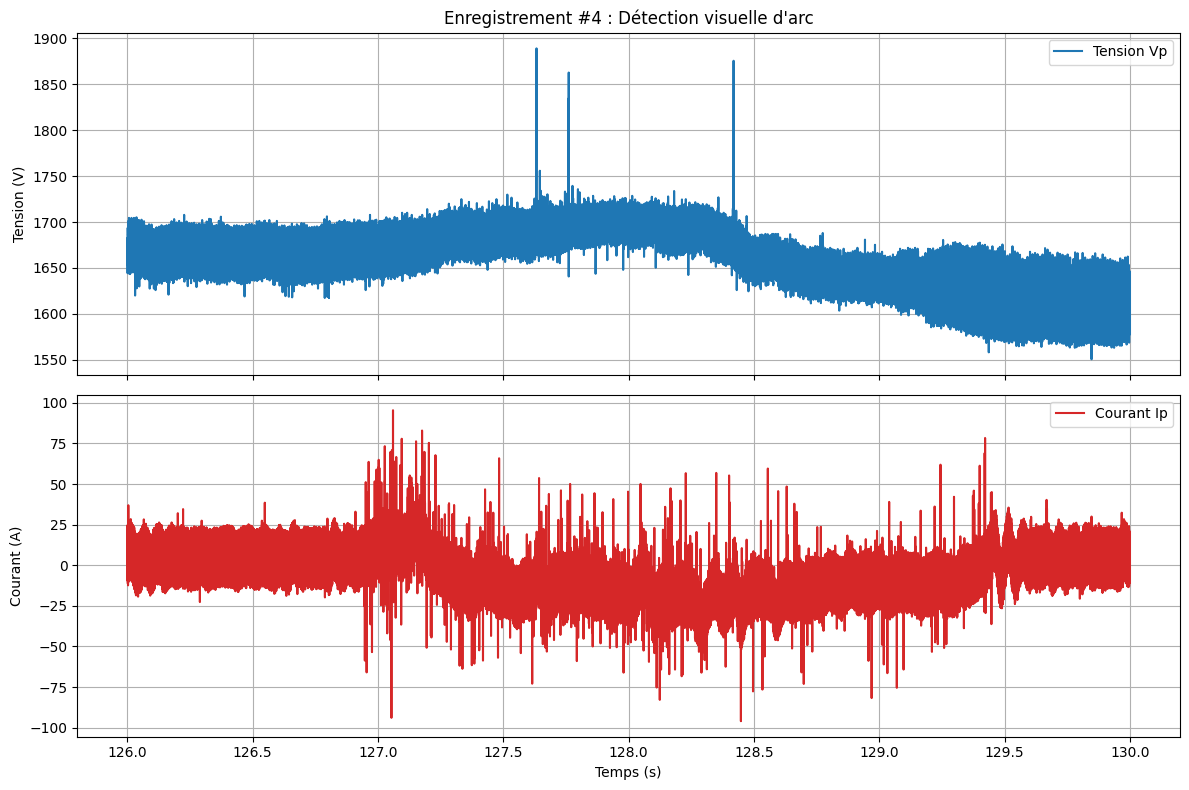

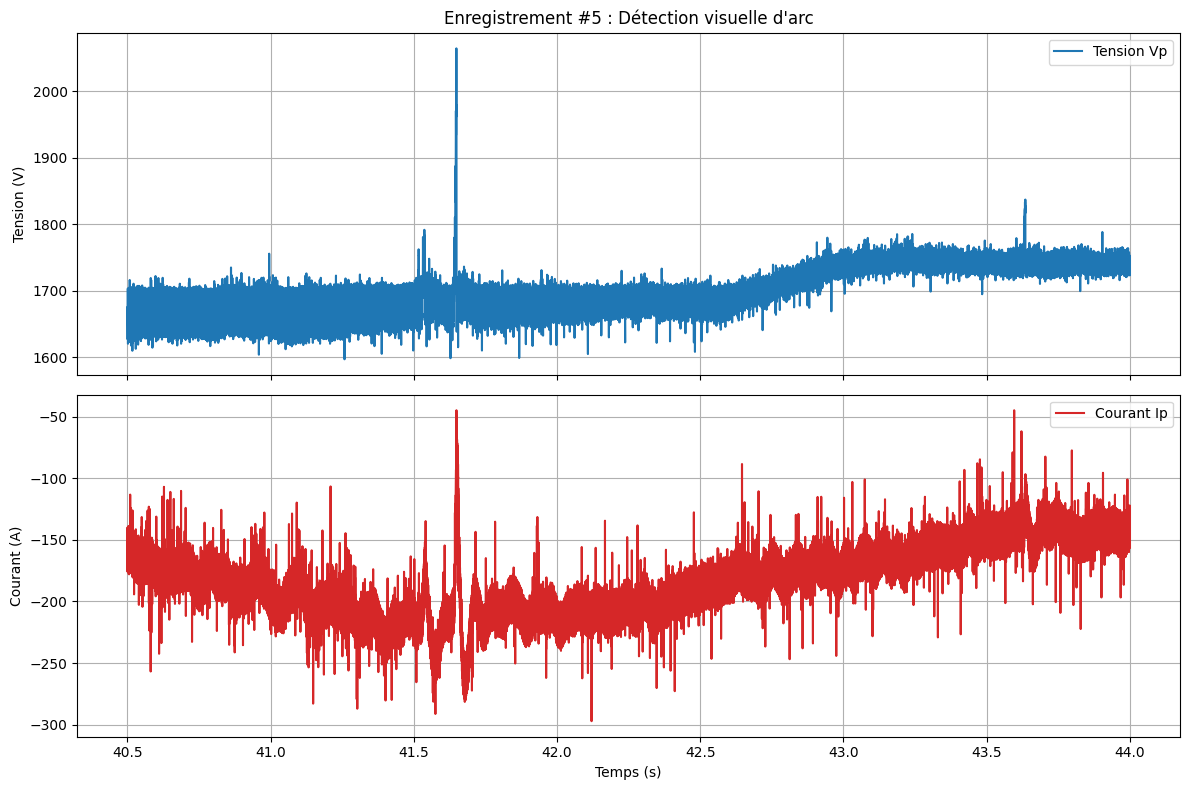

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import glob


liste_fichiers = glob.glob("MM_B_*_Vp.txt")

for fichier in sorted(liste_fichiers):
    
    id_freinage = fichier.split('_')[2]
    
    try:
        
        t  = pd.read_csv(f"MM_B_{id_freinage}_x.txt",  header=None, names=["time"])
        vp = pd.read_csv(f"MM_B_{id_freinage}_Vp.txt", header=None, names=["Vp"])
        ip = pd.read_csv(f"MM_B_{id_freinage}_Ip.txt", header=None, names=["Ip"])
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
        ax1.plot(t['time'], vp['Vp'], color='tab:blue', label='Tension Vp')
        ax1.set_title(f"Enregistrement #{id_freinage} : Détection visuelle d'arc")
        ax1.set_ylabel("Tension (V)")
        ax1.grid(True)
        ax1.legend(loc='upper right')
        
        ax2.plot(t['time'], ip['Ip'], color='tab:red', label='Courant Ip')
        ax2.set_ylabel("Courant (A)")
        ax2.set_xlabel("Temps (s)")
        ax2.grid(True)
        ax2.legend(loc='upper right')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Erreur lors de la lecture du freinage #{id_freinage} : {e}")



Méthode des seuils dynamiques

Analyse de 5 fichiers...
Echantillons Normaux : 1790
Echantillons Pré-Arc : 5


C:\Users\lucas\AppData\Local\Temp\ipykernel_72512\1490634035.py:98: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


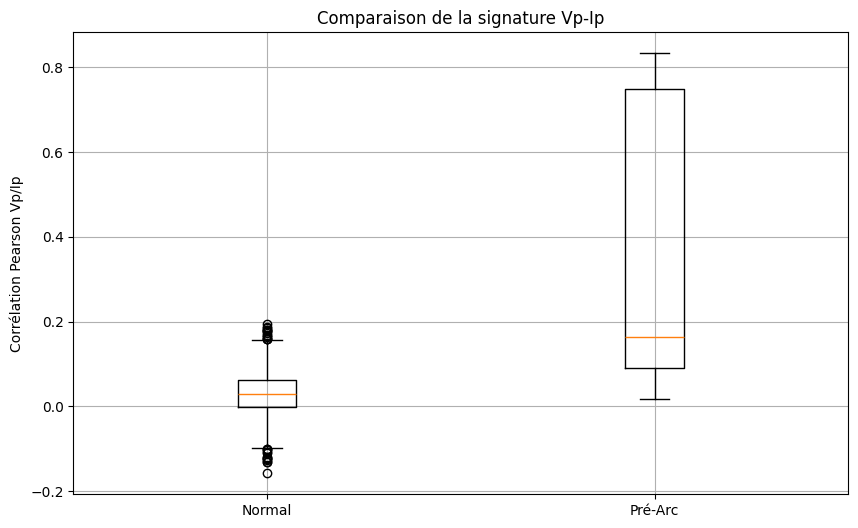

Echantillons Normaux générés : 1790


11.32638282574652

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np


WINDOW_SIZE = 50
PRE_ARC_WINDOW = 2000
SEUIL_SIGMA = 4

def charger_freinage(id_freinage):
    prefix = f"MM_B_{id_freinage}"
    try:
        vp = pd.read_csv(f"{prefix}_Vp.txt", header=None, names=["Vp"])
        x  = pd.read_csv(f"{prefix}_x.txt",  header=None, names=["time"])
        ip = pd.read_csv(f"{prefix}_Ip.txt", header=None, names=["Ip"])
        df = pd.concat([x, vp, ip], axis=1)
        return df
    except FileNotFoundError:
        return None

fichiers_vp = glob.glob("MM_B_*_Vp.txt")
ids_freinages = sorted(list(set([f.split('_')[2] for f in fichiers_vp])))

correlations_normal = []
correlations_pre_arc = []

print(f"Analyse de {len(ids_freinages)} fichiers...")

for id_f in ids_freinages:
    df = charger_freinage(id_f)
    if df is None or len(df) < (PRE_ARC_WINDOW * 2): continue # Fichier trop court
    
   
    df['Vp_std'] = df['Vp'].rolling(window=WINDOW_SIZE).std()
    

    median_std = df['Vp_std'].median()
    sigma_std = df['Vp_std'].std()
    seuil = median_std + (SEUIL_SIGMA * sigma_std)
    
  
    indices_instables = df.index[df['Vp_std'] > seuil].tolist()
 
    
    # CAS 1 : On a trouvé un arc
    if indices_instables:
        onset_idx = indices_instables[0] 
        
      
        if onset_idx > PRE_ARC_WINDOW:
            seg_danger = df.iloc[onset_idx - PRE_ARC_WINDOW : onset_idx]
            
            if seg_danger['Vp'].std() > 0.1 and seg_danger['Ip'].std() > 0.1:
                corr = seg_danger['Vp'].corr(seg_danger['Ip'])
                correlations_pre_arc.append(corr)

        fin_zone_saine = onset_idx - 2000
        
       
        for i in range(50, fin_zone_saine, 200):
            seg_normal = df.iloc[i : i + 200]
            
           
            if seg_normal['Vp'].std() > 0.1 and seg_normal['Ip'].std() > 0.1:
                corr_norm = seg_normal['Vp'].corr(seg_normal['Ip'])
                correlations_normal.append(corr_norm)
                
    # CAS 2 : Fichier totalement sain (Aucun arc détecté)
    else:
       
        mid = len(df) // 2
        seg_normal = df.iloc[mid : mid + PRE_ARC_WINDOW]
        if seg_normal['Vp'].std() > 0.1 and seg_normal['Ip'].std() > 0.1:
            corr_norm = seg_normal['Vp'].corr(seg_normal['Ip'])
            correlations_normal.append(corr_norm)


correlations_normal = [c for c in correlations_normal if not np.isnan(c)]
correlations_pre_arc = [c for c in correlations_pre_arc if not np.isnan(c)]

print(f"Echantillons Normaux : {len(correlations_normal)}")
print(f"Echantillons Pré-Arc : {len(correlations_pre_arc)}")


plt.figure(figsize=(10, 6))
data = []
labels = []

if correlations_normal:
    data.append(correlations_normal)
    labels.append('Normal')
if correlations_pre_arc:
    data.append(correlations_pre_arc)
    labels.append('Pré-Arc')

if data:
    plt.boxplot(data, labels=labels)
    plt.grid(True)
    plt.ylabel("Corrélation Pearson Vp/Ip")
    plt.title("Comparaison de la signature Vp-Ip")
    plt.show()

print(f"Echantillons Normaux générés : {len(correlations_normal)}")
df['Vp_std'].median()

On observe une forte corrélation intensité/tension en phase pré-arc, et une faible corrélation en phase "saine".

Isolation Forest sur deux features : écart type + résidu (Vp - médiane) sur fenêtre glissante de 50 valeurs

Entraînement sur 10% de l'échantillon, seuil = max phase d'entraînement x 1.25

Fichier MM_B_1 chargé : 150001 points.


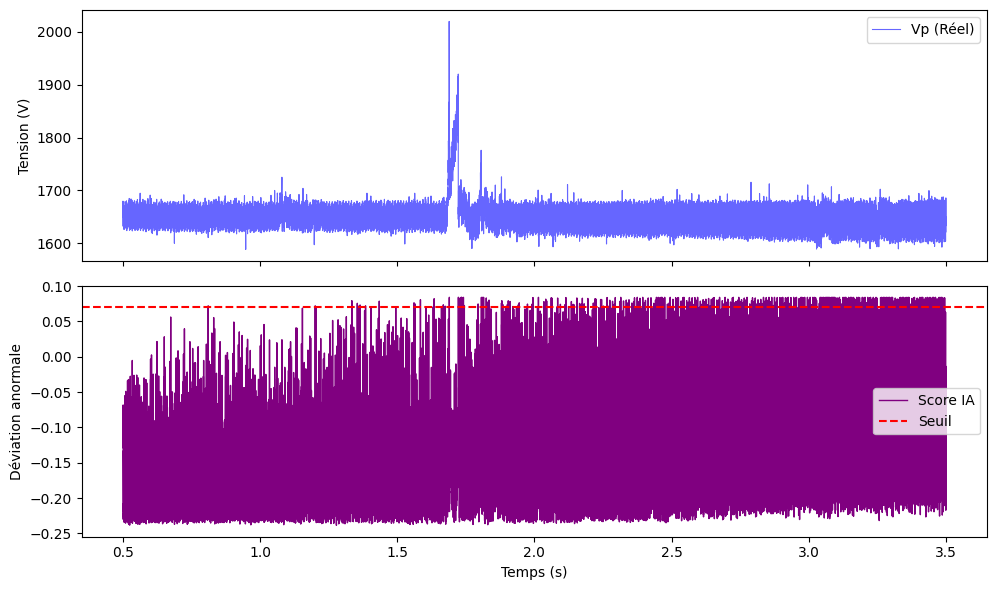

Fichier MM_B_2 chargé : 250001 points.


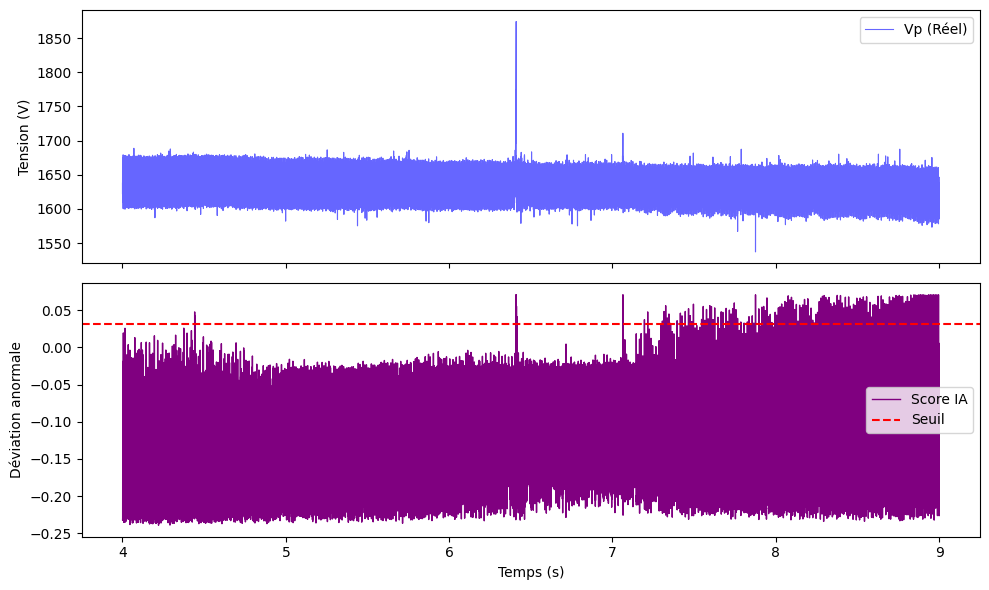

Fichier MM_B_3 chargé : 200001 points.


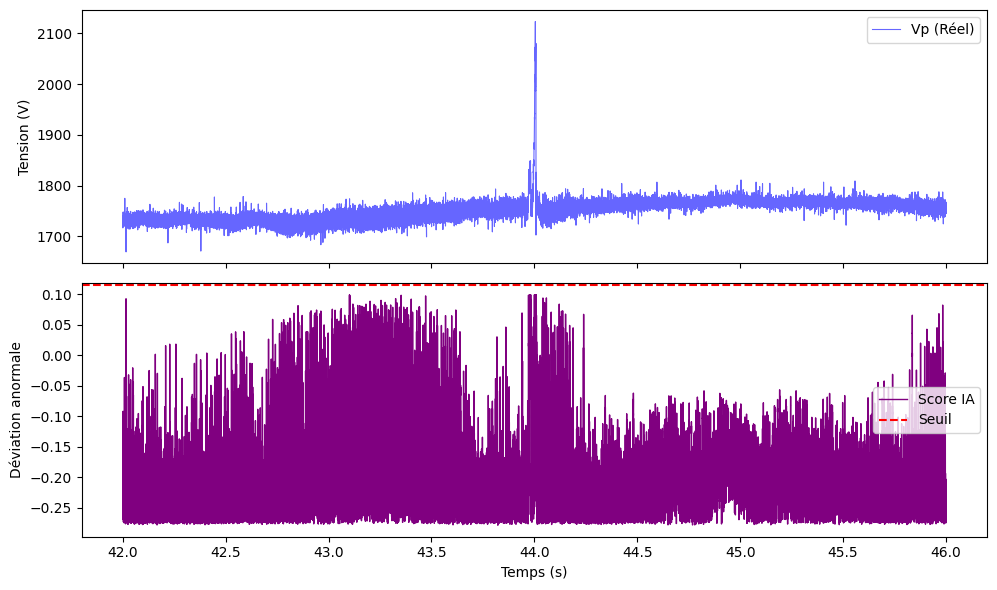

Fichier MM_B_4 chargé : 200001 points.


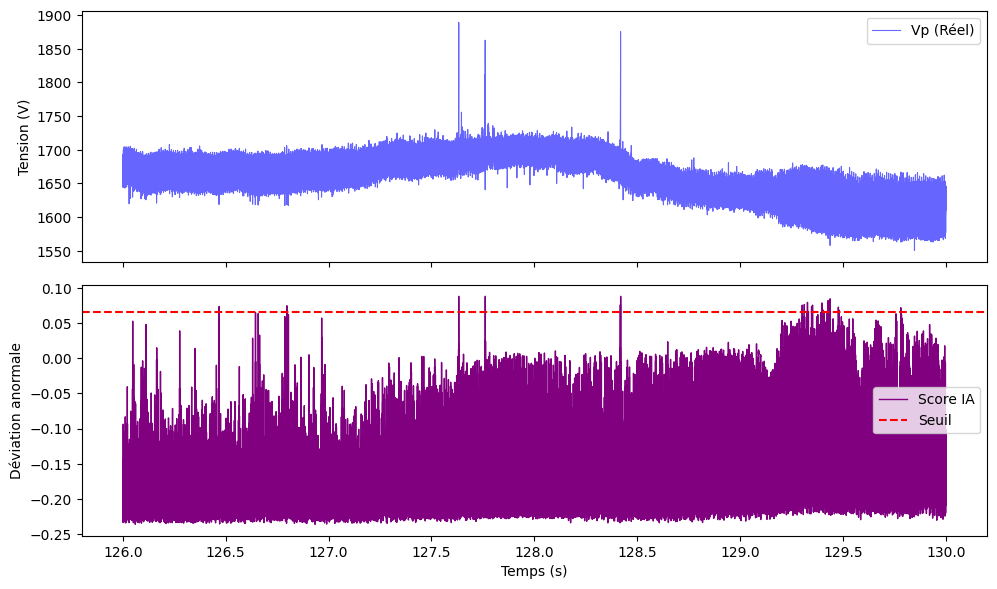

Fichier MM_B_5 chargé : 175001 points.


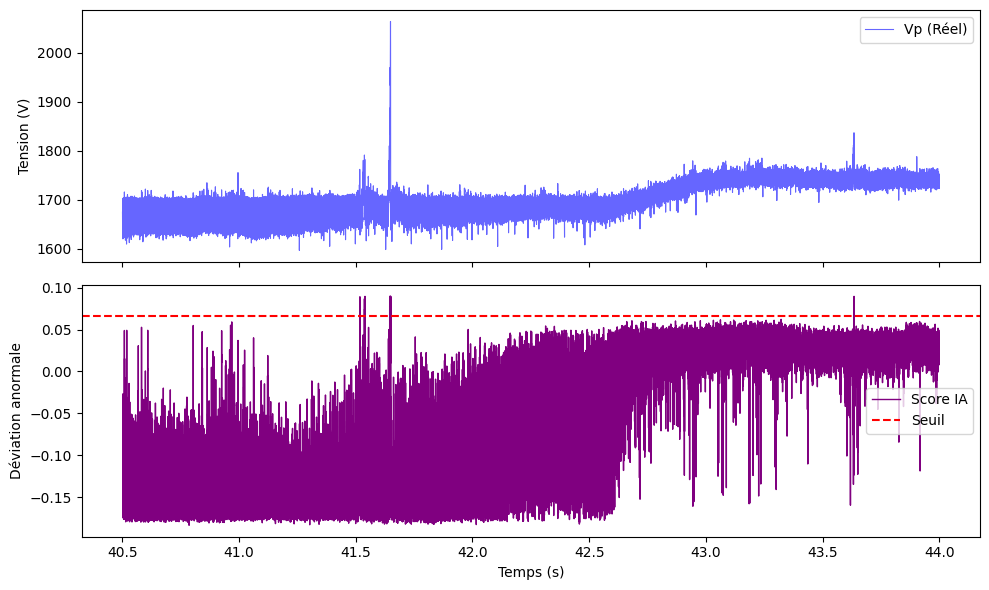

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

FENETRE = 50
NB_POINTS_TRAIN = 15000

fichiers = sorted(glob.glob("MM_B_*_Vp.txt"))

for fichier_vp in fichiers:
    ID_A_TESTER = "_".join(fichier_vp.split('_')[:3])
    try:
        vp = pd.read_csv(f"{ID_A_TESTER}_Vp.txt", header=None, names=["Vp"])
        ip = pd.read_csv(f"{ID_A_TESTER}_Ip.txt", header=None, names=["Ip"])
        temps = pd.read_csv(f"{ID_A_TESTER}_x.txt", header=None, names=["Time"])

        min_len = min(len(vp), len(ip), len(temps))
        df = pd.concat(
            [temps.iloc[:min_len], vp.iloc[:min_len], ip.iloc[:min_len]],
            axis=1
        )

        print(f"Fichier {ID_A_TESTER} chargé : {len(df)} points.")

    except FileNotFoundError:
        print(f"Erreur : fichiers manquants pour {ID_A_TESTER}")
        raise


    trend_vp = df['Vp'].rolling(FENETRE).median()

    df['Ecart_Vp'] = (df['Vp'] - trend_vp).abs()

    
    df['Std_Vp'] = df['Vp'].rolling(FENETRE).std()

    
    df_feat = df.dropna().copy()

   
    features = df_feat[['Ecart_Vp', 'Std_Vp']]

    scaler = StandardScaler()
    X = scaler.fit_transform(features)

    
    X_train = X[:NB_POINTS_TRAIN]

    model = IsolationForest(
        contamination=0.005,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train)

   
    df_feat['Score_IA'] = -model.decision_function(X)

   
    df_feat['Score_Lisse'] = df_feat['Score_IA'].rolling(5).mean().fillna(df_feat['Score_IA'])

    seuil = df_feat['Score_Lisse'].iloc[:NB_POINTS_TRAIN].max() * 1.25

   
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    ax1.plot(df['Time'], df['Vp'], label='Vp (Réel)', color='blue', linewidth=0.8, alpha=0.6)
    ax1.set_ylabel("Tension (V)")
    ax1.legend()
    

    ax2.plot(df['Time'].iloc[-len(df_feat):], df_feat['Score_Lisse'], 
         color='purple', linewidth=1, label="Score IA")
    ax2.axhline(seuil, color='red', linestyle='--', label="Seuil")
    ax2.set_ylabel("Déviation anormale")
    ax2.set_xlabel("Temps (s)")
    ax2.legend(loc='center right')
    
    plt.tight_layout()
    plt.show()
    
    
    
    


Le code ci-dessus détecte 4 anomalies à l'avance parmi les 5 évènements d'arc

Isolation Forest sur deux nouvelles features : la dérivée et le résidu (écart VP - médiane) sur une fenêtre de 50 valeurs

Entraînement sur 40 000 points, seuil = val abs du max phase d'entrainement x 1.1

Fichier MM_B_1 chargé : 150001 points.


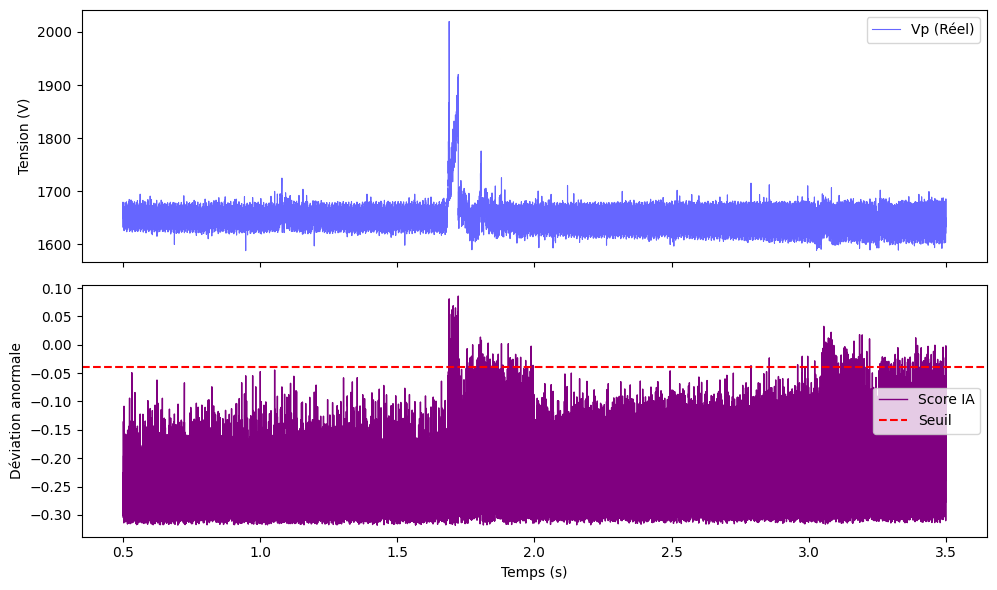

Fichier MM_B_2 chargé : 250001 points.


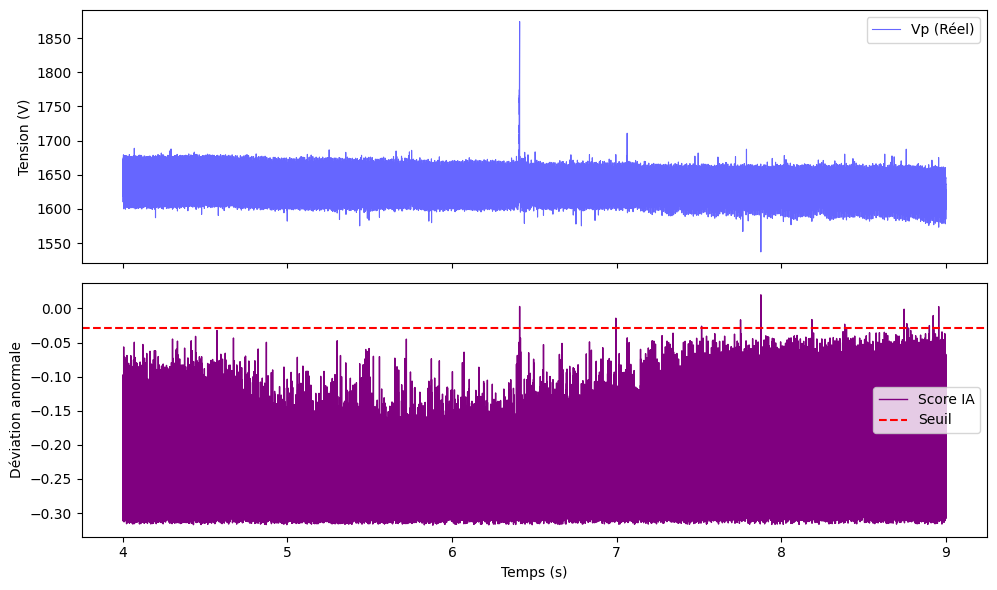

Fichier MM_B_3 chargé : 200001 points.


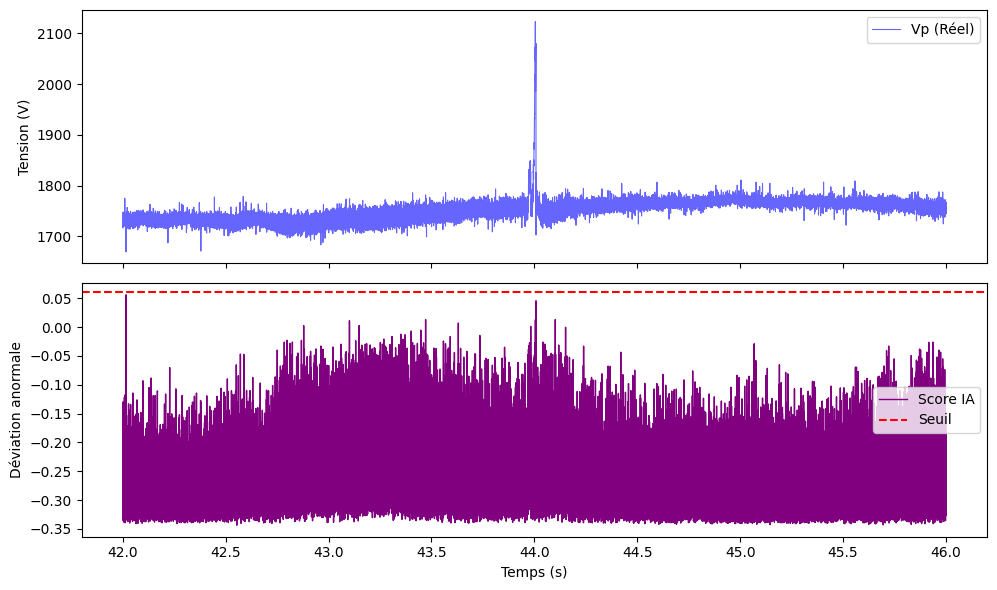

Fichier MM_B_4 chargé : 200001 points.


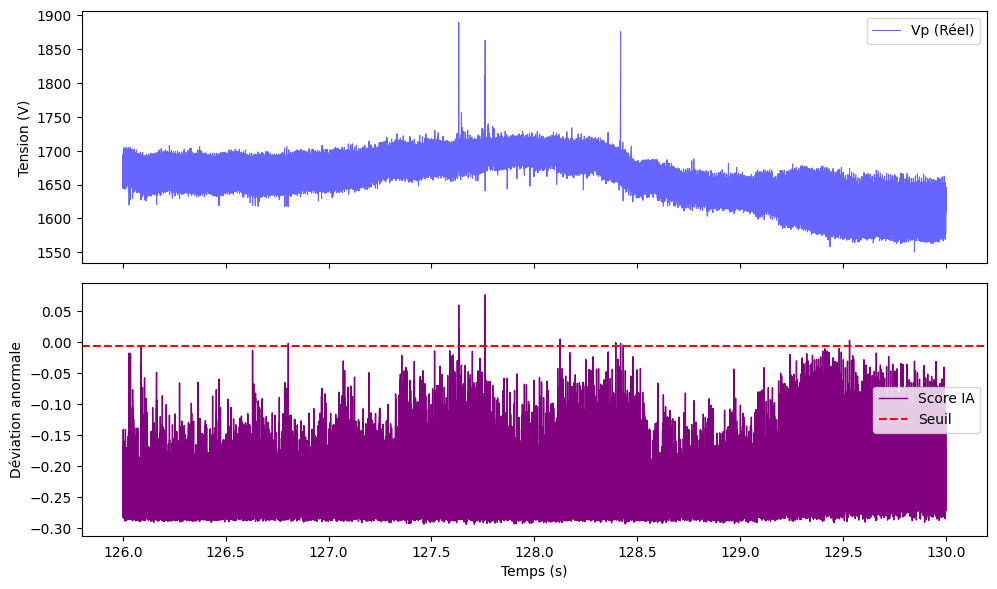

Fichier MM_B_5 chargé : 175001 points.


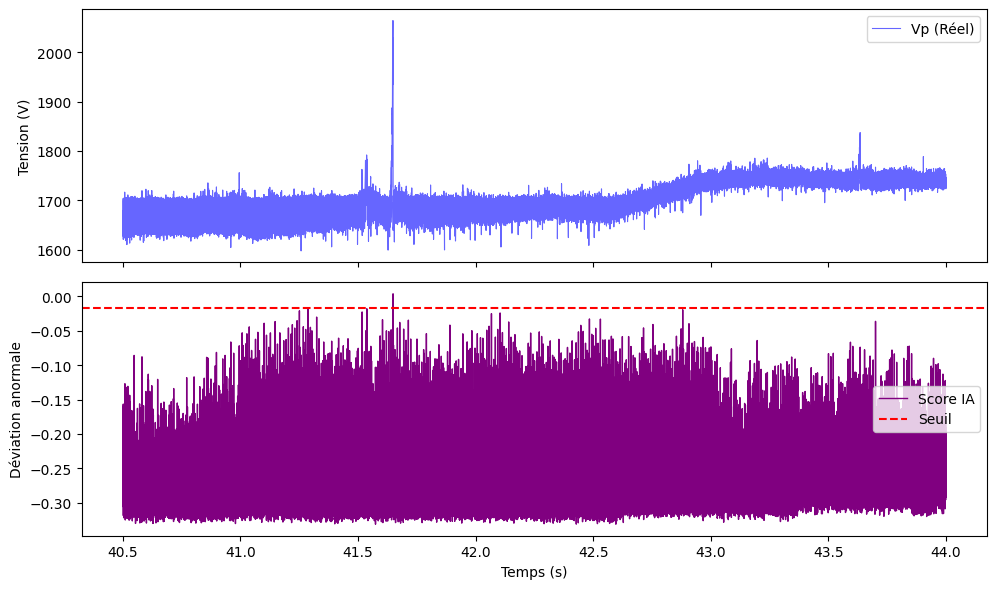

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

FENETRE = 50
NB_POINTS_TRAIN = 40000

fichiers = sorted(glob.glob("MM_B_*_Vp.txt"))

for fichier_vp in fichiers:
    ID_A_TESTER = "_".join(fichier_vp.split('_')[:3])
    try:
        vp = pd.read_csv(f"{ID_A_TESTER}_Vp.txt", header=None, names=["Vp"])
        ip = pd.read_csv(f"{ID_A_TESTER}_Ip.txt", header=None, names=["Ip"])
        temps = pd.read_csv(f"{ID_A_TESTER}_x.txt", header=None, names=["Time"])

        min_len = min(len(vp), len(ip), len(temps))
        df = pd.concat(
            [temps.iloc[:min_len], vp.iloc[:min_len], ip.iloc[:min_len]],
            axis=1
        )

        print(f"Fichier {ID_A_TESTER} chargé : {len(df)} points.")

    except FileNotFoundError:
        print(f"Erreur : fichiers manquants pour {ID_A_TESTER}")
        raise


    trend_vp = df['Vp'].rolling(FENETRE).median()

    df['Residu'] = (df['Vp'] - trend_vp.abs())
    df['Vitesse'] = df['Vp'].diff().abs().fillna(0)

    
    df_feat = df.dropna().copy()

   
    features = df_feat[['Residu', 'Vitesse']]

    scaler = StandardScaler()
    X = scaler.fit_transform(features)

    
    X_train = X[:NB_POINTS_TRAIN]

    model = IsolationForest(
        contamination=0.005,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train)

   
    df_feat['Score_IA'] = -model.decision_function(X)

   
    df_feat['Score_Lisse'] = df_feat['Score_IA'].rolling(5).mean().fillna(df_feat['Score_IA'])

    seuil = df_feat['Score_Lisse'].iloc[:NB_POINTS_TRAIN].max()
    seuil = seuil + abs(seuil)*0.1


   
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    ax1.plot(df['Time'], df['Vp'], label='Vp (Réel)', color='blue', linewidth=0.8, alpha=0.6)
    ax1.set_ylabel("Tension (V)")
    ax1.legend()
    

    ax2.plot(df['Time'].iloc[-len(df_feat):], df_feat['Score_Lisse'], 
         color='purple', linewidth=1, label="Score IA")
    ax2.axhline(seuil, color='red', linestyle='--', label="Seuil")
    ax2.set_ylabel("Déviation anormale")
    ax2.set_xlabel("Temps (s)")
    ax2.legend(loc='center right')
    
    plt.tight_layout()
    plt.show()
    
    
    
    


Fonctionne légèrement moins bien que l'Isolation Forest avec l'écart-type (seulement 2 détections ici et un seuil plus bas) - peut être encore ajusté ceci-dit

avec résidu lissé et fenetre de 200 points pour la médiane (ISO forest)

C:\Users\lucas\AppData\Local\Temp\ipykernel_72512\1387218050.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Mediane'] = df['Vp'].rolling(FENETRE_TENDANCE).median().fillna(method='bfill')


--- MM_B_1 ---
❌ Pas de détection.


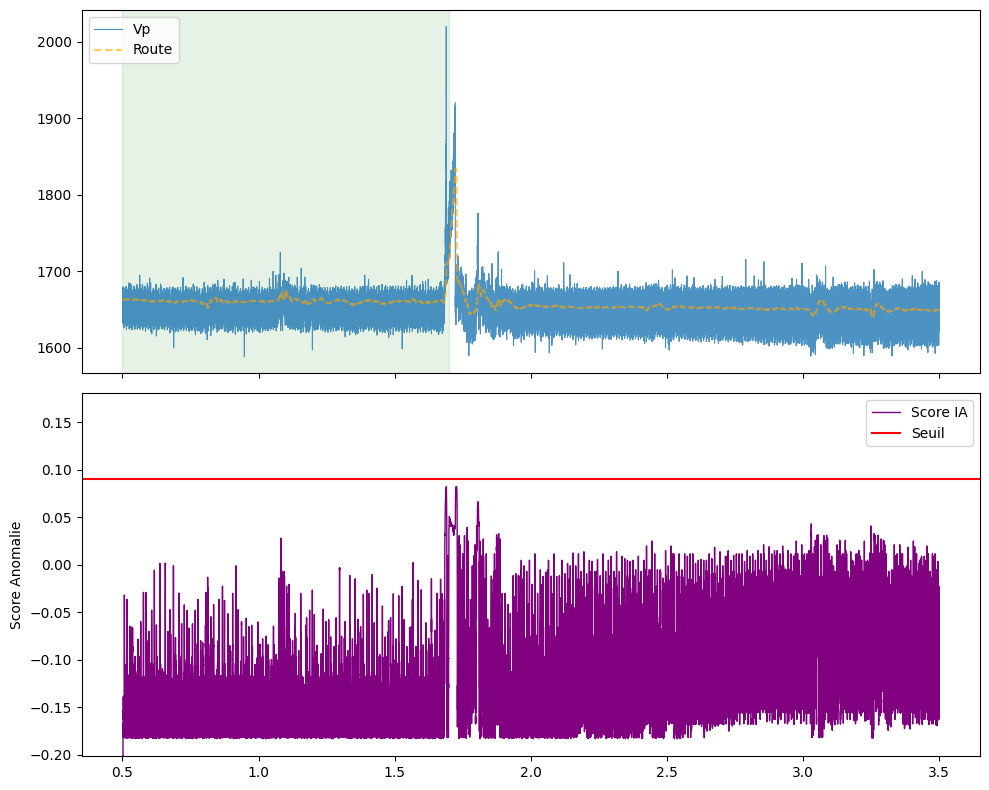

C:\Users\lucas\AppData\Local\Temp\ipykernel_72512\1387218050.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Mediane'] = df['Vp'].rolling(FENETRE_TENDANCE).median().fillna(method='bfill')


--- MM_B_2 ---
❌ Pas de détection.


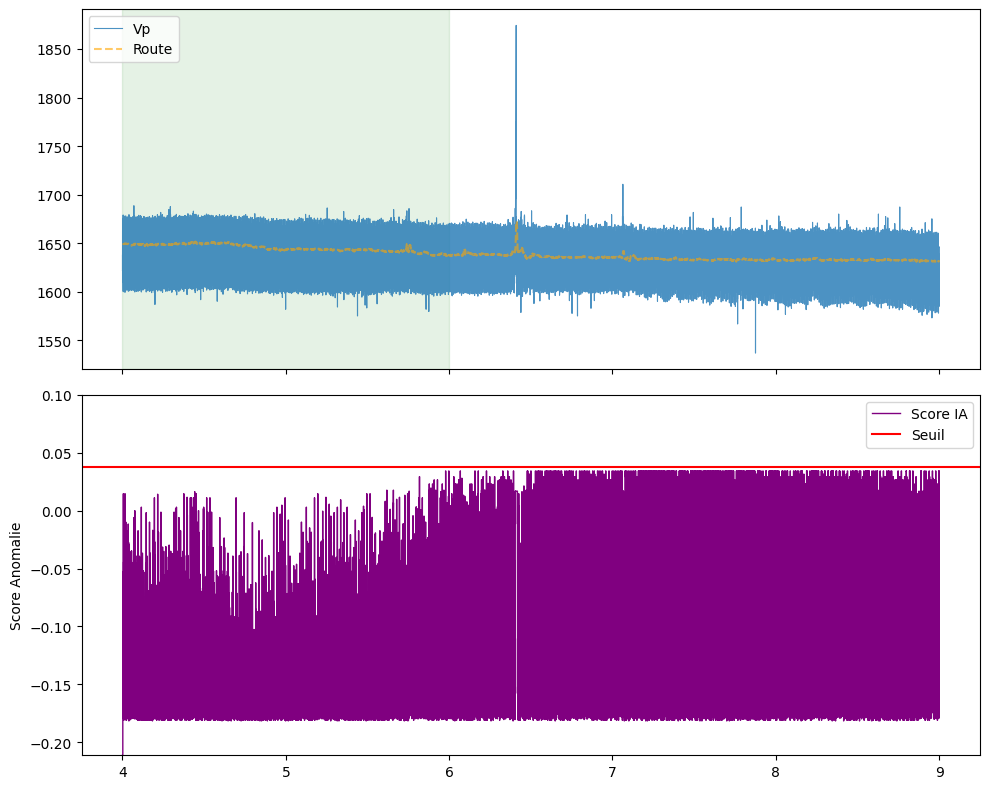

C:\Users\lucas\AppData\Local\Temp\ipykernel_72512\1387218050.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Mediane'] = df['Vp'].rolling(FENETRE_TENDANCE).median().fillna(method='bfill')


--- MM_B_3 ---
❌ Pas de détection.


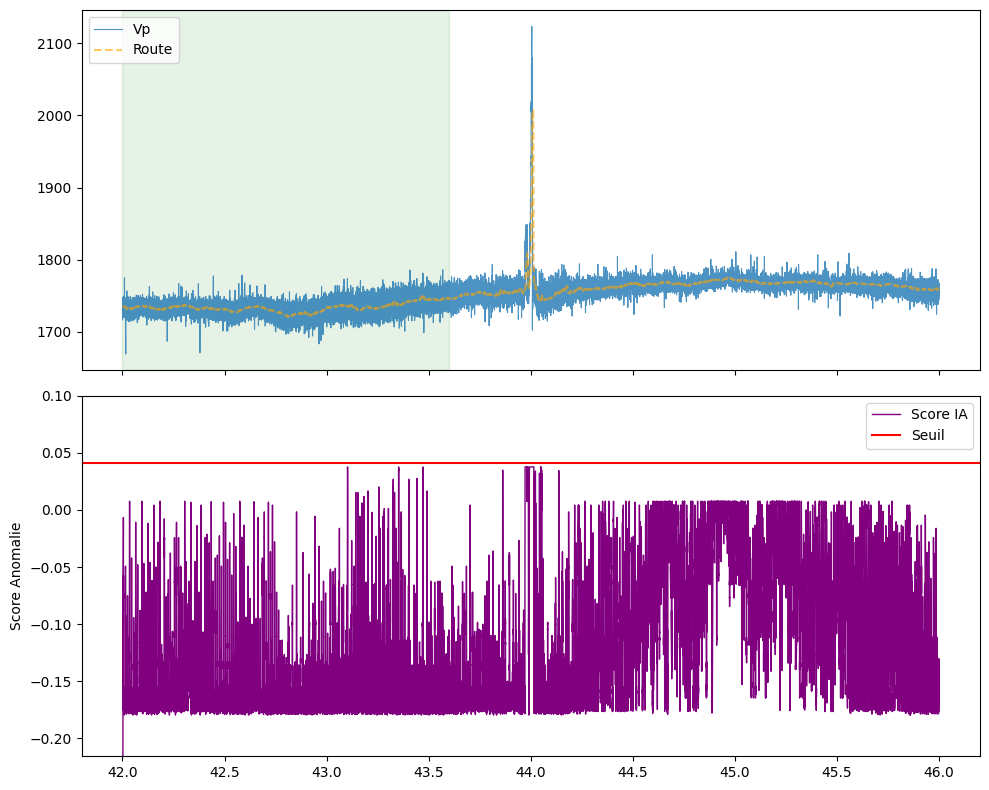

C:\Users\lucas\AppData\Local\Temp\ipykernel_72512\1387218050.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Mediane'] = df['Vp'].rolling(FENETRE_TENDANCE).median().fillna(method='bfill')


--- MM_B_4 ---
❌ Pas de détection.


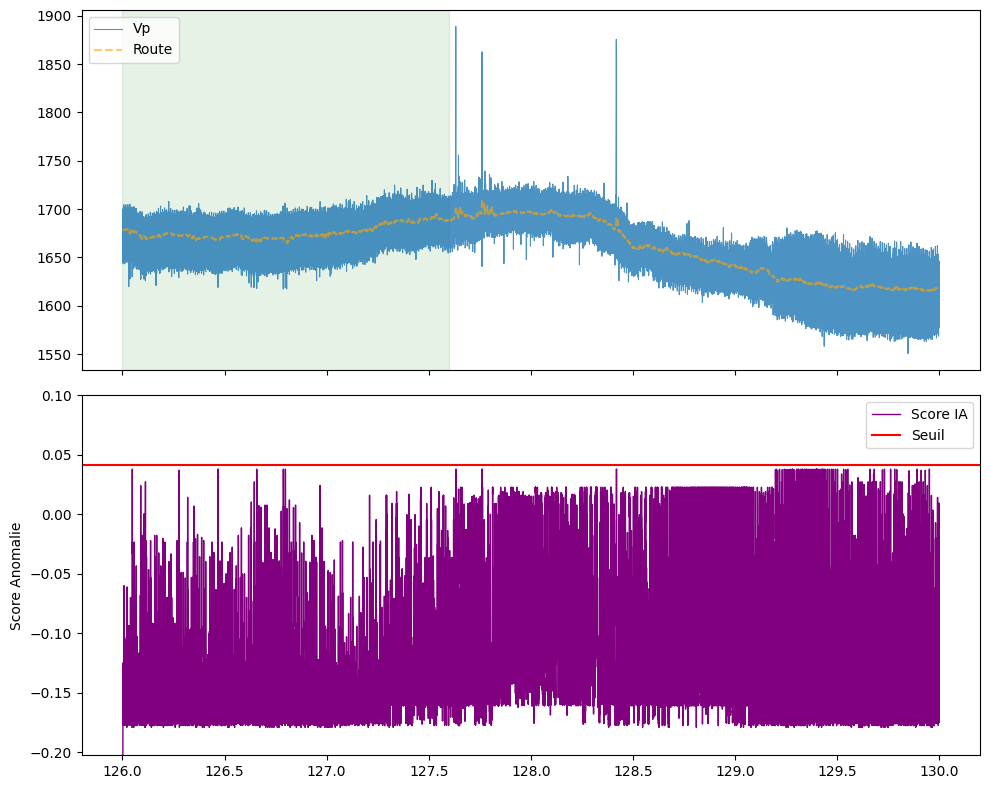

C:\Users\lucas\AppData\Local\Temp\ipykernel_72512\1387218050.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Mediane'] = df['Vp'].rolling(FENETRE_TENDANCE).median().fillna(method='bfill')


--- MM_B_5 ---
❌ Pas de détection.


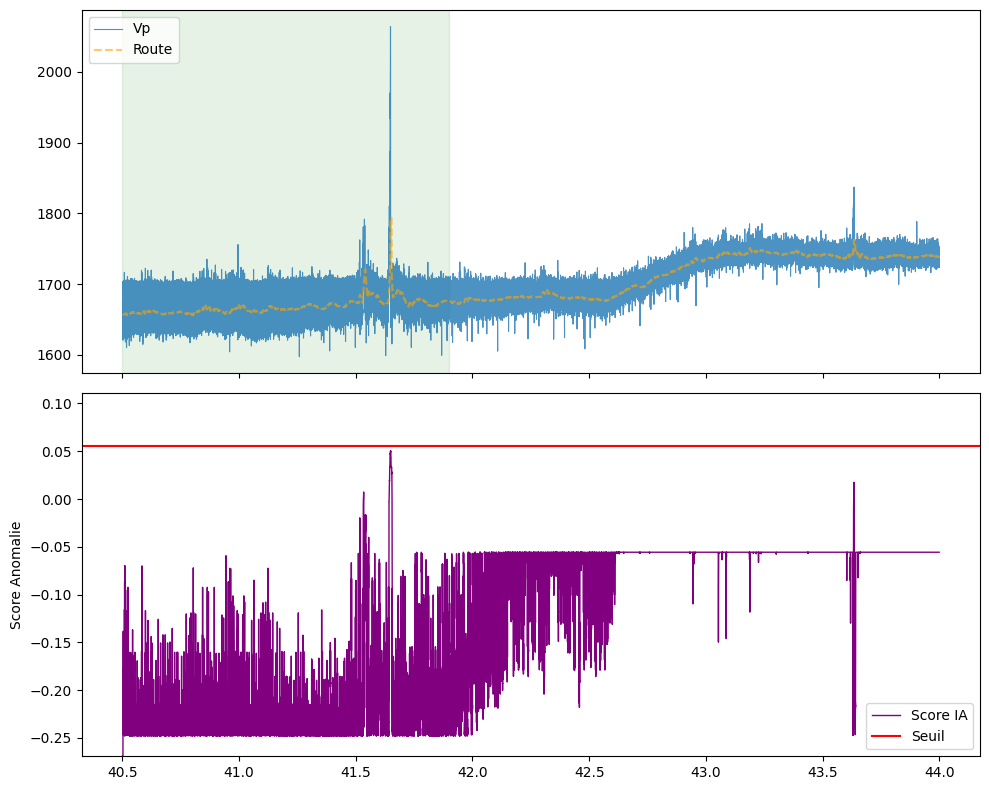

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# --- CONFIGURATION ---
FENETRE_TENDANCE = 500   # Pour la ligne médiane (la route)
FENETRE_FILTRE = 100     # NOUVEAU : Pour nettoyer le résidu avant l'IA
RATIO_APPRENTISSAGE = 0.40

fichiers = sorted(glob.glob("MM_B_*_Vp.txt"))

for fichier_vp in fichiers:
    id_test = "_".join(fichier_vp.split('_')[:3])
    
    try:
        # 1. CHARGEMENT
        vp = pd.read_csv(f"{id_test}_Vp.txt", header=None, names=["Vp"], delim_whitespace=True)
        temps = pd.read_csv(f"{id_test}_x.txt", header=None, names=["Time"], delim_whitespace=True)
        min_len = min(len(vp), len(temps))
        df = pd.concat([temps.iloc[:min_len], vp.iloc[:min_len]], axis=1)

        # 2. FEATURE ENGINEERING
        # A. La Route (Médiane)
        df['Mediane'] = df['Vp'].rolling(FENETRE_TENDANCE).median().fillna(method='bfill')
        
        # B. Le Résidu Brut (C'est là que vous arrêtiez avant)
        df['Residu_Brut'] = (df['Vp'] - df['Mediane']).abs()
        
        # C. LE FILTRAGE MAGIQUE (C'est ça qui manquait !)
        # On lisse le résidu. Le bruit de fond s'écrase, l'arc reste.
        df['Feature_IA'] = df['Residu_Brut'].rolling(FENETRE_FILTRE).mean()

        # 3. APPRENTISSAGE
        limit_train = int(len(df) * RATIO_APPRENTISSAGE)
        scaler = StandardScaler()
        
        # On donne le résidu FILTRÉ à l'IA
        X = scaler.fit_transform(df[['Feature_IA']])
        
        # Contamination un peu plus élevée pour être sûr de capter les pics
        model = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)
        model.fit(X[:limit_train])

        # 4. SCORE
        df['Score'] = -model.decision_function(X)
        
        # Seuil : On prend le max calme + marge confortable
        max_calme = df['Score'].iloc[:limit_train].max()
        seuil = max(max_calme * 1.1, 0.01) # Marge de 50%

        anomalies = df[(df['Score'] > seuil) & (df.index > limit_train)]

        # 5. RESULTATS
        print(f"--- {id_test} ---")
        if not anomalies.empty:
            print(f"🚨 ARC DÉTECTÉ À : {anomalies['Time'].iloc[0]:.4f} s")
        else:
            print("❌ Pas de détection.")

        # 6. GRAPHIQUE
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
        
        # HAUT : Vrai signal
        ax1.plot(df['Time'], df['Vp'], linewidth=0.8, alpha=0.8, label="Vp")
        ax1.plot(df['Time'], df['Mediane'], color='orange', linestyle='--', alpha=0.6, label="Route")
        ax1.axvspan(df['Time'].iloc[0], df['Time'].iloc[limit_train], color='green', alpha=0.1)
        if not anomalies.empty:
            ax1.axvline(anomalies['Time'].iloc[0], color='red', linewidth=2, linestyle='--')
        ax1.legend(loc='upper left')
        
        # BAS : Score IA (Sur données filtrées)
        # Vous allez voir que la courbe violette est beaucoup plus basse et propre
        ax2.plot(df['Time'], df['Score'], color='purple', linewidth=1, label="Score IA")
        ax2.axhline(seuil, color='red', label="Seuil")
        ax2.fill_between(df['Time'], 0, df['Score'], where=(df['Score'] > seuil), color='red', alpha=0.5)
        
        # Zoom pour voir le détachement
        ax2.set_ylim(min(df['Score']), max(seuil * 2, 0.1))
        ax2.set_ylabel("Score Anomalie")
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(e)

Isolation Forest avec deux features : corrélation Ip/Vp et écart-type (ne semble pas fonctionner)

Fichier MM_B_2 chargé : 250001 points.


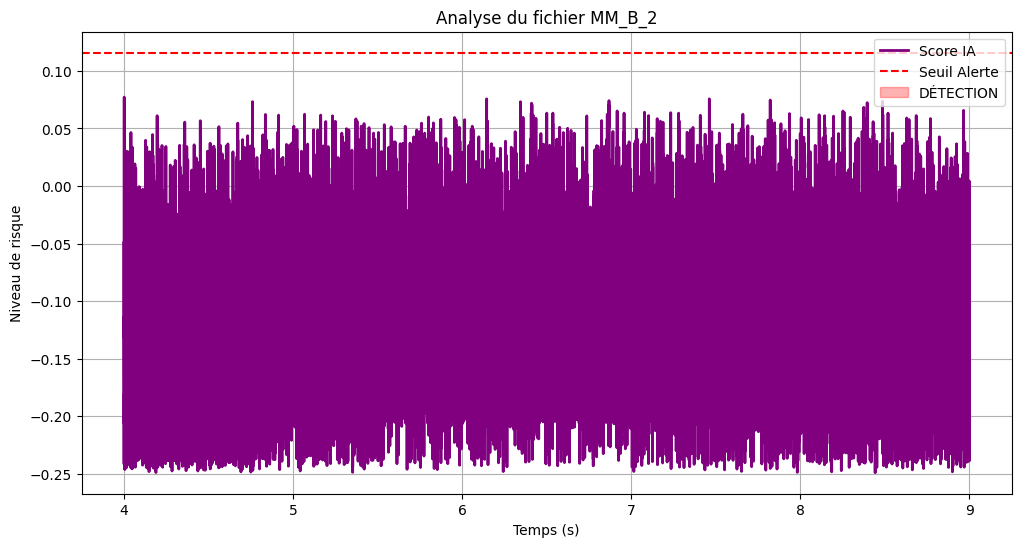

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

ID_A_TESTER = "MM_B_2"  
FENETRE = 50            

try:
    vp = pd.read_csv(f"{ID_A_TESTER}_Vp.txt", header=None, names=["Vp"])
    ip = pd.read_csv(f"{ID_A_TESTER}_Ip.txt", header=None, names=["Ip"])
    temps = pd.read_csv(f"{ID_A_TESTER}_x.txt", header=None, names=["Time"])
    
    df = pd.concat([temps, vp, ip], axis=1)
    print(f"Fichier {ID_A_TESTER} chargé : {len(df)} points.")

except FileNotFoundError:
    print(f"Erreur : Impossible de trouver les fichiers pour {ID_A_TESTER}")
    exit()

# 2. CALCUL DES INDICATEURS (FEATURES)
# On garde la même taille que l'original en remplaçant les trous par 0
df['Corr'] = df['Vp'].rolling(FENETRE).corr(df['Ip']).fillna(0)
df['Std']  = df['Vp'].rolling(FENETRE).std().fillna(0)

# 3. L'IA (ISOLATION FOREST)
# On prépare les données pour l'IA
features = df[['Corr', 'Std']]

# On entraîne l'IA seulement sur les 400 premiers points (Zone calme)
# On suppose que le train roule normalement au début de l'enregistrement
scaler = StandardScaler()
X_train = scaler.fit_transform(features.iloc[:400])

model = IsolationForest(contamination=0.01, random_state=42)
model.fit(X_train)

# 4. PRÉDICTION
# On teste sur TOUT le fichier
X_complet = scaler.transform(features)
# Le score est inversé : Plus il est haut, plus c'est grave
df['Score_IA'] = -model.decision_function(X_complet)

# 5. AFFICHAGE
plt.figure(figsize=(12, 6))

# Courbe du Score d'Anomalie (Violet)
plt.plot(df['Time'], df['Score_IA'], color='purple', label="Score IA", linewidth=2)

# Ligne Rouge d'Alerte (Basée sur le max du début calme)
seuil = df['Score_IA'].iloc[:400].max() * 1.5
plt.axhline(y=seuil, color='red', linestyle='--', label="Seuil Alerte")

# Colorier quand ça dépasse
plt.fill_between(df['Time'], -0.5, df['Score_IA'], 
                 where=(df['Score_IA'] > seuil), 
                 color='red', alpha=0.3, label="DÉTECTION")

plt.title(f"Analyse du fichier {ID_A_TESTER}")
plt.xlabel("Temps (s)")
plt.ylabel("Niveau de risque")
plt.legend()
plt.grid(True)
plt.show()



Auto-encoder tentative 1

C:\Users\lucas\AppData\Local\Temp\ipykernel_72512\1782039146.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  trend_vp = df['Vp'].rolling(FENETRE_TENDANCE).median().fillna(method='bfill')


--- MM_B_1 ---
⚡ ARC DÉTECTÉ À : 1.6346 s


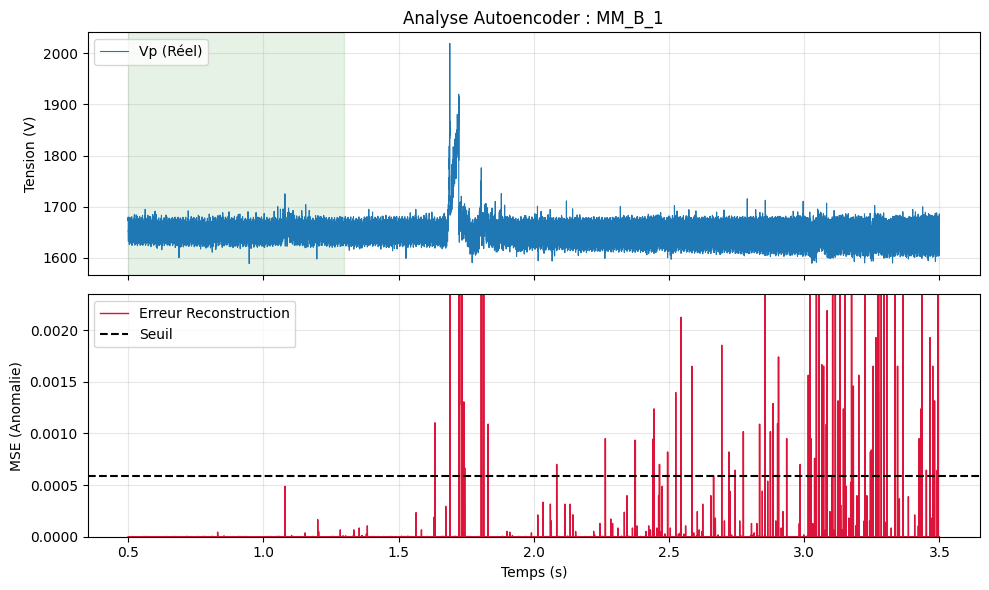

C:\Users\lucas\AppData\Local\Temp\ipykernel_72512\1782039146.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  trend_vp = df['Vp'].rolling(FENETRE_TENDANCE).median().fillna(method='bfill')


--- MM_B_2 ---
⚡ ARC DÉTECTÉ À : 6.4103 s


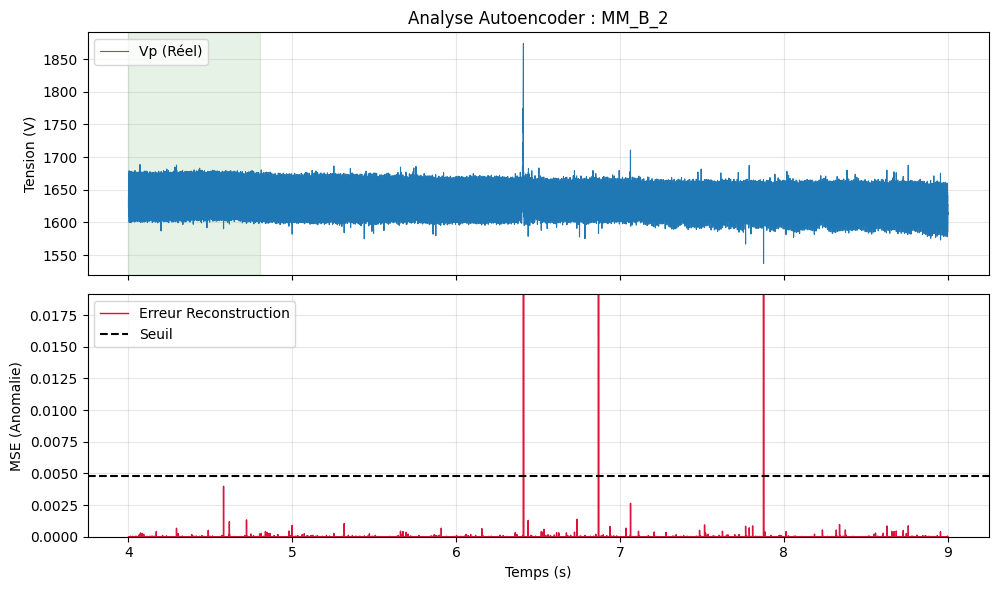

C:\Users\lucas\AppData\Local\Temp\ipykernel_72512\1782039146.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  trend_vp = df['Vp'].rolling(FENETRE_TENDANCE).median().fillna(method='bfill')


--- MM_B_3 ---
⚡ ARC DÉTECTÉ À : 44.0048 s


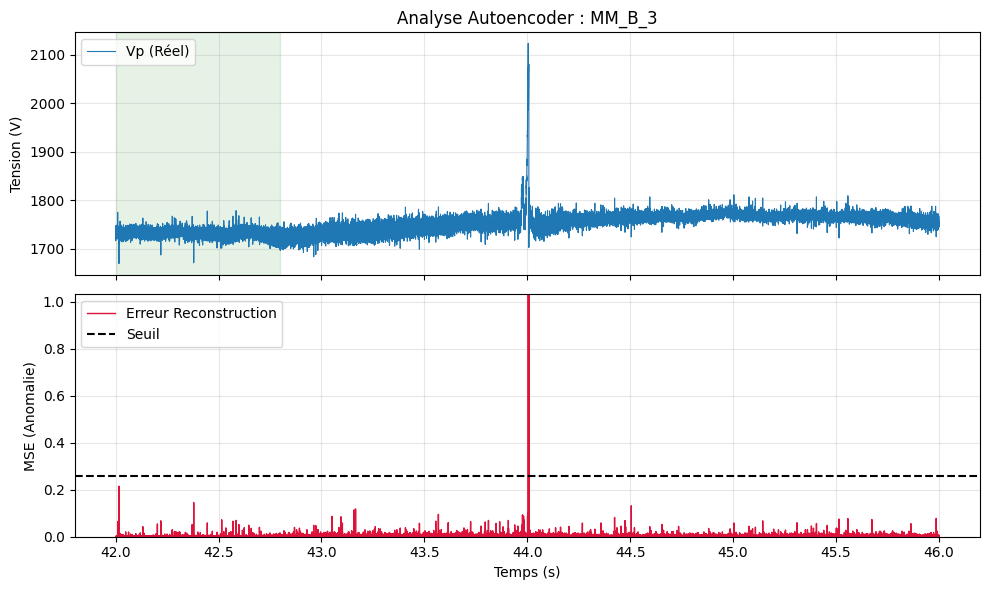

C:\Users\lucas\AppData\Local\Temp\ipykernel_72512\1782039146.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  trend_vp = df['Vp'].rolling(FENETRE_TENDANCE).median().fillna(method='bfill')


--- MM_B_4 ---
⚡ ARC DÉTECTÉ À : 127.6322 s


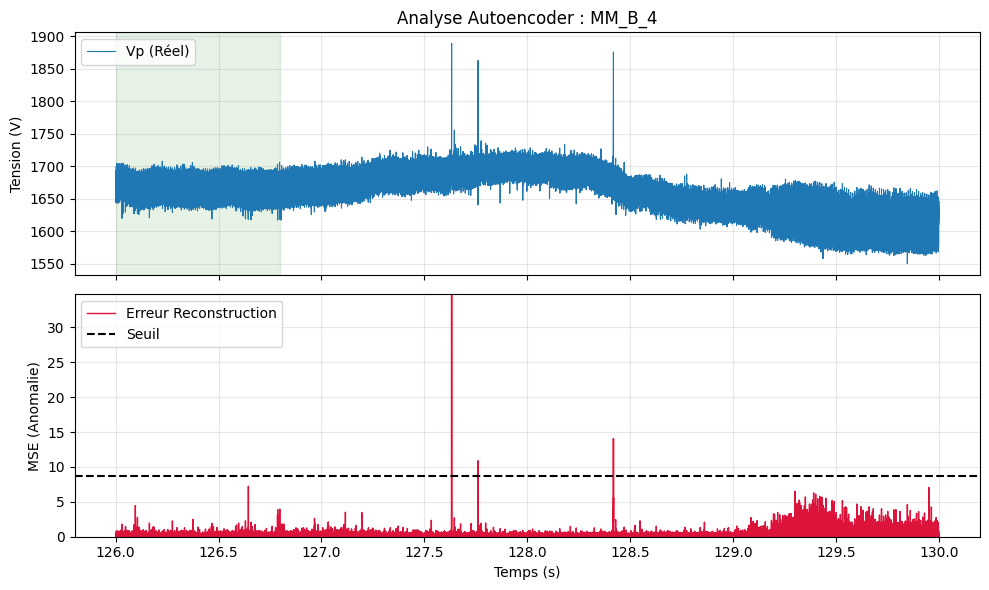

C:\Users\lucas\AppData\Local\Temp\ipykernel_72512\1782039146.py:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  trend_vp = df['Vp'].rolling(FENETRE_TENDANCE).median().fillna(method='bfill')


--- MM_B_5 ---
⚡ ARC DÉTECTÉ À : 41.5174 s


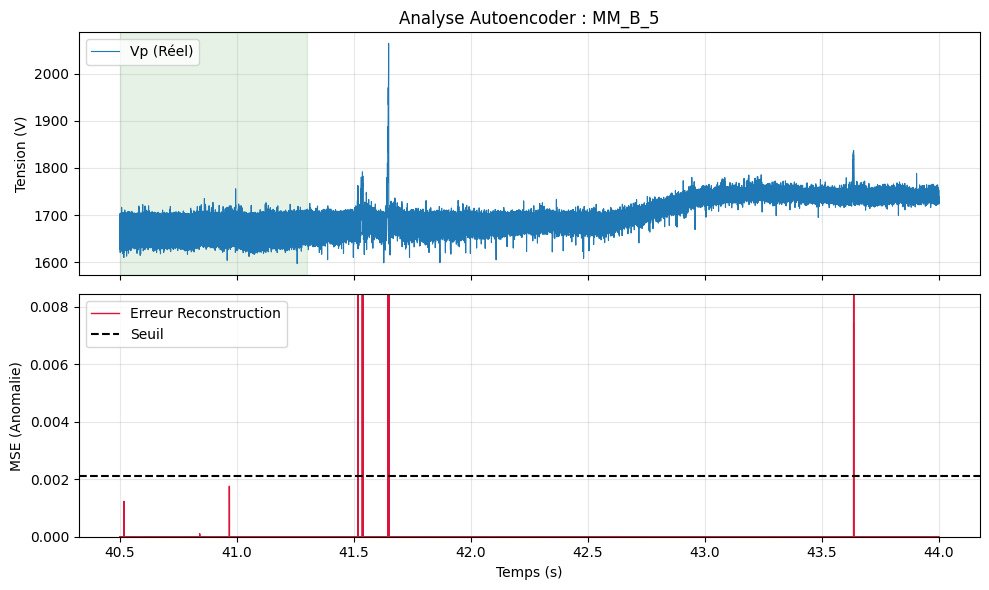

In [9]:
import glob
from sklearn.preprocessing import StandardScaler

# On utilise TensorFlow/Keras pour le réseau de neurones
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# --- CONFIGURATION ---
FENETRE_TENDANCE = 50
NB_POINTS_TRAIN = 40000  # On apprend le "calme" ici
SEUIL_MARGE = 1.2        # Marge de sécurité au-dessus du bruit max (20%)

fichiers = sorted(glob.glob("MM_B_*_Vp.txt"))

for fichier_vp in fichiers:
    ID_A_TESTER = "_".join(fichier_vp.split('_')[:3])
    
    try:
        # 1. CHARGEMENT
        vp = pd.read_csv(f"{ID_A_TESTER}_Vp.txt", header=None, names=["Vp"])
        temps = pd.read_csv(f"{ID_A_TESTER}_x.txt", header=None, names=["Time"])
        
        min_len = min(len(vp), len(temps))
        df = pd.concat([temps.iloc[:min_len], vp.iloc[:min_len]], axis=1)
        
        # 2. FEATURE ENGINEERING (On garde votre recette qui marche)
        # Calcul de la tendance (Médiane glissante)
        trend_vp = df['Vp'].rolling(FENETRE_TENDANCE).median().fillna(method='bfill')
        
        # Résidu (Ecart à la normale)
        df['Residu'] = (df['Vp'] - trend_vp).abs()
        
        # Vitesse (Dérivée pour voir les changements rapides)
        df['Vitesse'] = df['Vp'].diff().abs().fillna(0)
        
        # Préparation des données pour le réseau
        # On utilise Residu et Vitesse comme "image" de l'état du système
        features_columns = ['Residu', 'Vitesse']
        data = df[features_columns].values
        
        # 3. NORMALISATION (Crucial pour les réseaux de neurones)
        scaler = StandardScaler()
        # On fit le scaler UNIQUEMENT sur la zone d'entrainement pour ne pas tricher
        scaler.fit(data[:NB_POINTS_TRAIN])
        data_scaled = scaler.transform(data)
        
        # Séparation Train (Sain) / Test (Tout)
        X_train = data_scaled[:NB_POINTS_TRAIN]
        
        # 4. CONSTRUCTION DE L'AUTOENCODER
        # Dimension d'entrée (ici 2 : Residu et Vitesse)
        input_dim = X_train.shape[1]
        
        # Architecture "Sablier" : On compresse l'info puis on la décompresse
        input_layer = Input(shape=(input_dim,))
        
        # Encoder : On compresse les features
        encoder = Dense(8, activation="relu")(input_layer)
        encoder = Dense(4, activation="relu")(encoder)
        
        # Bottleneck (Goulot d'étranglement) : L'essence du signal
        bottleneck = Dense(2, activation="relu")(encoder)
        
        # Decoder : On essaie de reconstruire
        decoder = Dense(4, activation="relu")(bottleneck)
        decoder = Dense(8, activation="relu")(decoder)
        output_layer = Dense(input_dim, activation="linear")(decoder)
        
        autoencoder = Model(inputs=input_layer, outputs=output_layer)
        
        # Compilation et Entrainement
        # On utilise 'mse' (Mean Squared Error) car on veut minimiser l'erreur de reconstruction
        autoencoder.compile(optimizer='adam', loss='mse')
        
        # Entrainement rapide (epochs=10 suffit souvent pour des signaux simples)
        # verbose=0 pour ne pas polluer la console
        history = autoencoder.fit(X_train, X_train, 
                                  epochs=20, 
                                  batch_size=32, 
                                  shuffle=True, 
                                  verbose=0)
        
        # 5. DÉTECTION (Calcul de l'erreur de reconstruction)
        # L'IA essaie de reconstruire tout le fichier
        reconstructions = autoencoder.predict(data_scaled, verbose=0)
        
        # L'erreur, c'est la différence au carré entre l'entrée et la sortie (MSE)
        # On fait la moyenne des erreurs sur les 2 features (Residu et Vitesse)
        mse = np.mean(np.power(data_scaled - reconstructions, 2), axis=1)
        
        df['Reconstruction_Error'] = mse
        
        # Lissage léger de l'erreur pour éviter les faux pics uniques
        df['Error_Lisse'] = df['Reconstruction_Error'].rolling(5).mean().fillna(0)

        # 6. SEUIL DYNAMIQUE
        # On regarde l'erreur max commise pendant l'entrainement (sur le sain)
        max_train_error = df['Error_Lisse'].iloc[:NB_POINTS_TRAIN].max()
        seuil = max_train_error * SEUIL_MARGE
        
        # Recherche anomalie
        anomalies = df[(df['Error_Lisse'] > seuil) & (df.index > NB_POINTS_TRAIN)]
        
        print(f"--- {ID_A_TESTER} ---")
        if not anomalies.empty:
            t_first = anomalies['Time'].iloc[0]
            print(f"⚡ ARC DÉTECTÉ À : {t_first:.4f} s")
        else:
            print("✅ Aucun arc détecté.")

        # 7. GRAPHIQUE
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

        # HAUT : Le signal physique
        ax1.plot(df['Time'], df['Vp'], label='Vp (Réel)', color='#1f77b4', linewidth=0.8)
        # Zone d'apprentissage en vert
        ax1.axvspan(df['Time'].iloc[0], df['Time'].iloc[NB_POINTS_TRAIN], color='green', alpha=0.1)
        ax1.set_ylabel("Tension (V)")
        ax1.legend(loc='upper left')
        ax1.set_title(f"Analyse Autoencoder : {ID_A_TESTER}")
        ax1.grid(True, alpha=0.3)

        # BAS : L'Erreur de Reconstruction (Ce que l'IA ne comprend pas)
        ax2.plot(df['Time'], df['Error_Lisse'], color='crimson', linewidth=1, label="Erreur Reconstruction")
        ax2.axhline(seuil, color='black', linestyle='--', linewidth=1.5, label="Seuil")
        
        # Remplissage quand ça dépasse
        ax2.fill_between(df['Time'], 0, df['Error_Lisse'], 
                         where=(df['Error_Lisse'] > seuil), color='red', alpha=0.5)

        # Zoom intelligent sur l'axe Y pour voir les petits départs
        # On limite le zoom pour ne pas être écrasé par le pic final de l'arc
        ax2.set_ylim(0, seuil * 4)
        
        ax2.set_ylabel("MSE (Anomalie)")
        ax2.set_xlabel("Temps (s)")
        ax2.legend(loc='upper left')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Erreur sur {ID_A_TESTER} : {e}")

Détecte à l'avance 2 arcs sur 5, à améliorer